<a href="https://colab.research.google.com/github/hemanthkumar17/Economics-Coding-Project-2020/blob/main/Univariate_Analysis_of_Aerosol_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Univariate Analysis of Aerosol Index of Various Cities in India


In [ ]:
!git clone https://github.com/aneeshsharma/AerosolIndexAnalysis.git

fatal: destination path 'AerosolIndexAnalysis' already exists and is not an empty directory.


In [ ]:
cd AerosolIndexAnalysis/data

/content/AerosolIndexAnalysis/data/AerosolIndexAnalysis/data


In [ ]:
import glob
import pandas as pd

glued_data = pd.DataFrame()
file_names = []
dataframes = []
for file_name in glob.glob('./*.csv'):
    dataframes.append(pd.read_csv(file_name, low_memory=False))
    file_names.append(file_name[2:])

In [ ]:
file_names

['mumbai_weekly.csv',
 'pune_weekly.csv',
 'ahmadabad_weekly.csv',
 'bangalore_weekly.csv',
 'hyderabad_weekly.csv',
 'kolkata_weekly.csv',
 'delhi_weekly.csv',
 'chennai_weekly.csv',
 'jaipur_weekly.csv',
 'bhopal_weekly.csv']

In [ ]:
index = file_names.index('bangalore_weekly.csv')
dataframes[index]['ward_no'] = dataframes[index]['WARD_NO']

In [ ]:
clean = []
for df in dataframes:
  clean.append(df[['ward_no', 'date', 'mean']])

## Univariate Analysis
Here, we take the mean of the Aerosol Index of all wards within cities on each date and plot it. We group the rows by date and take the mean of all the values.

In [ ]:
avg = []
for city in clean:
    avg.append(city.groupby('date').agg({'mean': ['mean']}).reset_index())

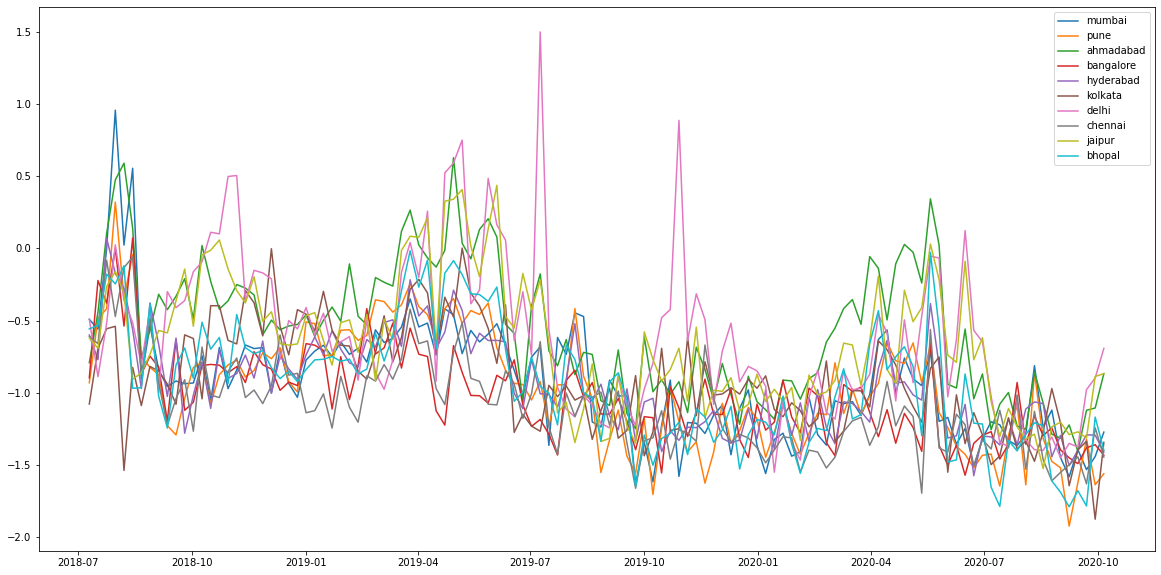

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
city_names = [name[:name.index('_')] for name in file_names]

plt.figure(figsize=(20, 10))
for i in range(len(avg)):
    city = avg[i]
    plt.plot(city['date'], city['mean']['mean'])
    # city.plot(x='date', y='mean', figsize=(20, 10), kind='line', title=city_names[i])
plt.legend(city_names)
plt.savefig("mean_plot.png", quality=95)

We can notice that other than a few deviations, most of the cities experience very similar Aerosol Index values, especially in the recent years. We can also note that this graph is slowly decreasing in the recent years, which implies that overall, the Aerosol content's effect has been reducing in the recent years.

# **Heatmap Analysis**
Heatmap analysis of each city based on their wards and dates.

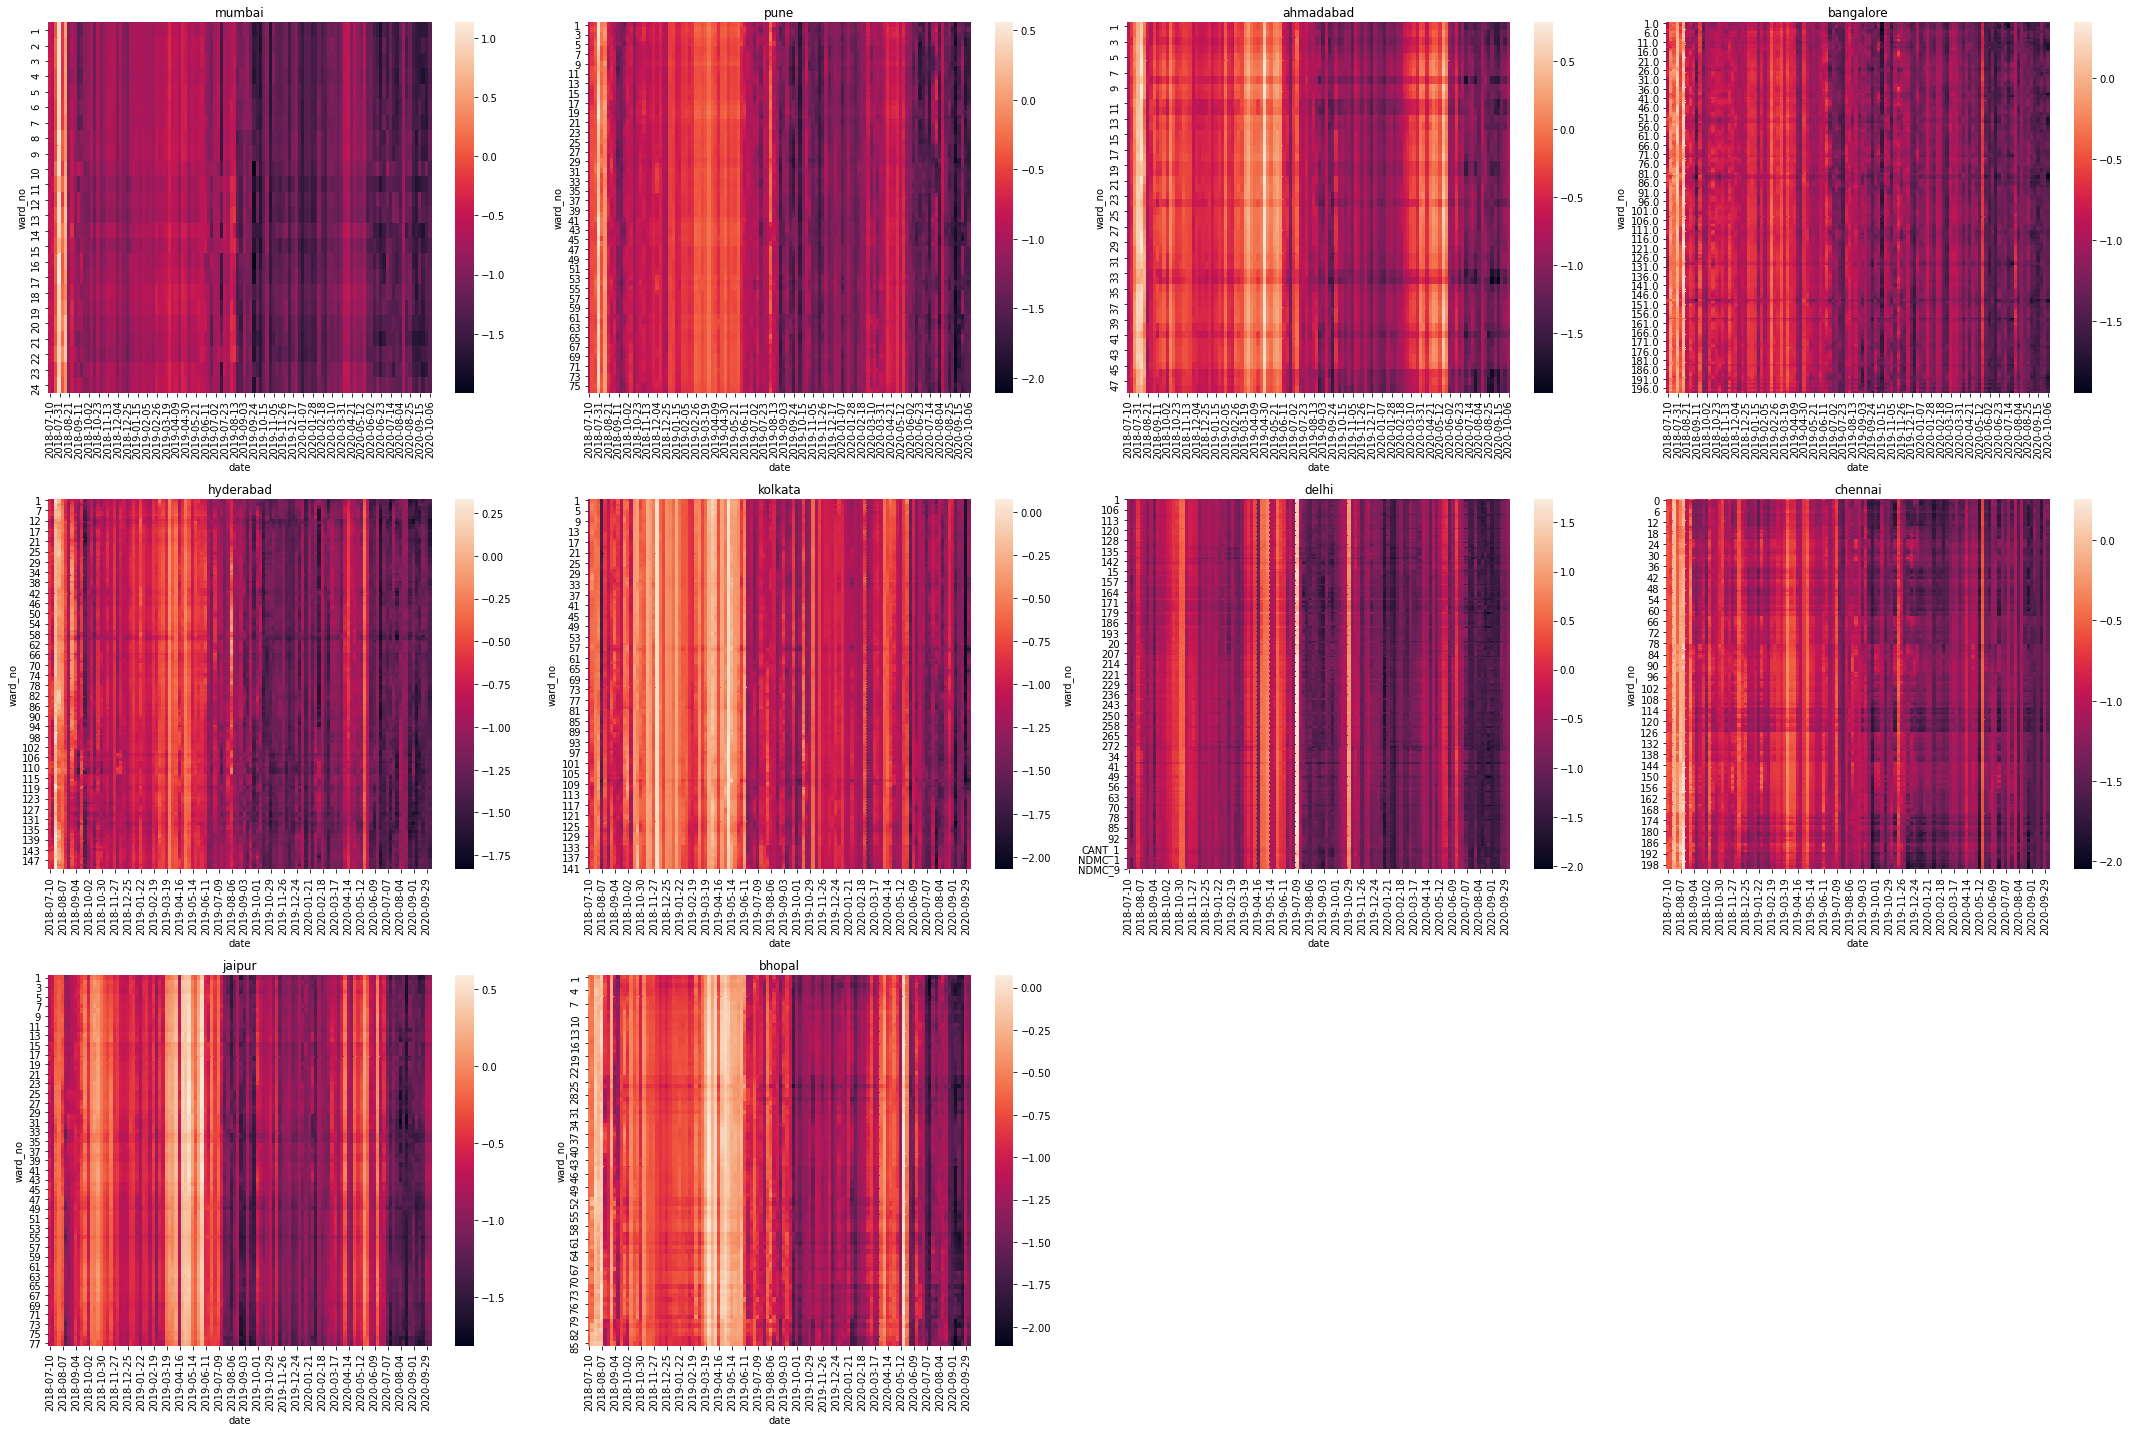

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 20))
for i in range(len(clean)):
    df = clean[i]
    plt.subplot(3, 4, i + 1)
    plt.title(city_names[i])
    plt.tight_layout()
    df_wide=df.pivot_table(index='ward_no', columns='date', values='mean')
    p2=sns.heatmap( df_wide ,linewidths=0)
plt.savefig("heat_plot.png", quality=95)

In order to analyse the differences between the cities, we can plot the change in the average Aerosol Index for each city over the timespan of 27 months. This can gives us an idea of the performance of cities to counter pollution.

In [ ]:
change = []
for city in avg:
    init = float(city.loc[0]['mean']['mean'])
    final = float(city.loc[len(city) - 1]['mean']['mean'])
    change.append(final - init)

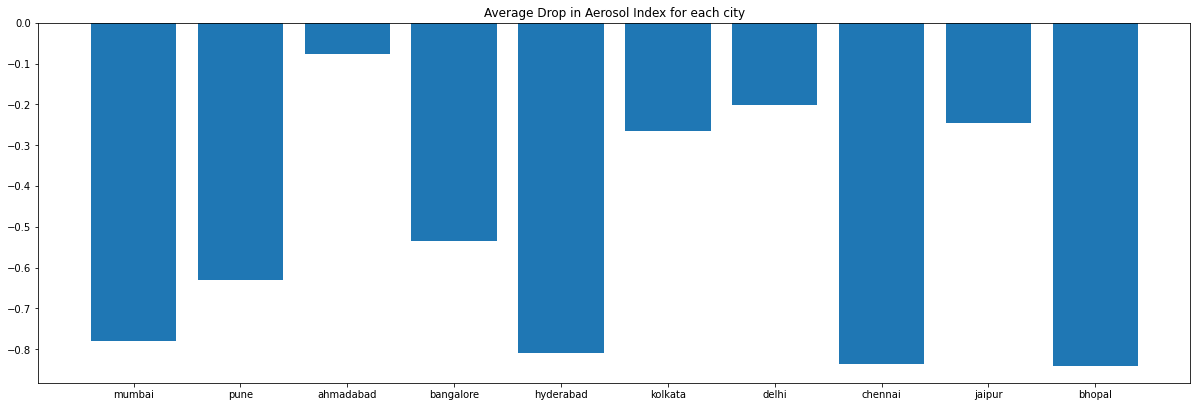

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(city_names,change)
plt.title('Average Drop in Aerosol Index for each city')
plt.show()
plt.savefig("drop_plot.png", quality=95)

## Conclusion from Univariate Analysis
The bar plot above shows how the different cities part of this analysis performed over time to counter pollution. It can be infered from the data that Bhopal performed the best with the highest drop in Aerosol Index while Ahmadabad performed the worst with the lowest drop in Aerosol Index.

#Prediction of Aerosol Index

In this part, we build an AI model : Deep Learning Artificial Neural Network to learn the time series and predict upcoming Aersol indices to observe how the Aerosol content has and will be changing.

In [ ]:
new_avg = [pd.DataFrame(df) for df in avg]

In [ ]:
for df in new_avg:
  df['date'] = pd.to_datetime(df['date'])

In [ ]:
import torch
from torch import nn
import numpy as np

#####Data Pre-Processing

In [ ]:
y_train = [[float(value)] for value in new_avg[0]['mean']['mean']]
y_train = torch.from_numpy(np.array(y_train))

In [ ]:
x_train = [[value, value**2, np.exp(value)/10**20] for value in [float((pd.Timestamp(x).value/1000000)/(1000 * 60 * 60 * 24 * 365)) for x in new_avg[0]['date']]]
x_train = torch.from_numpy(np.asarray(x_train))

#####Model Initialisation

In [ ]:
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.linear1 = nn.Linear(3, 6)
    self.linear2 = nn.Linear(6, 6)
    self.linear3 = nn.Linear(6, 1)

  def forward(self, x):
    out = self.linear1(x)
    out = self.linear2(out)
    out = self.linear3(out)
    return out

###Training the model
We are training the model in this step, and plotting the predicted curve that best fits the data

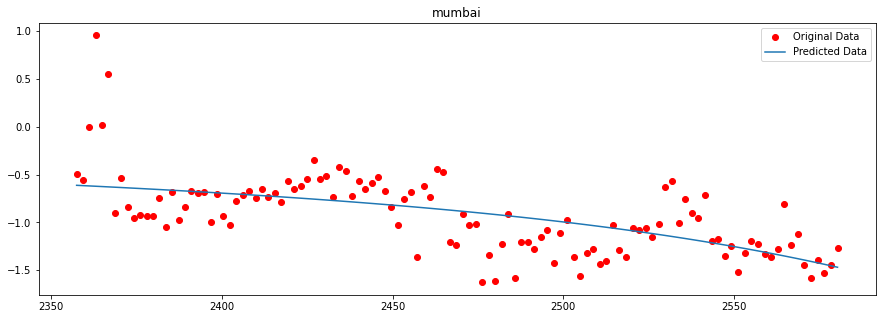

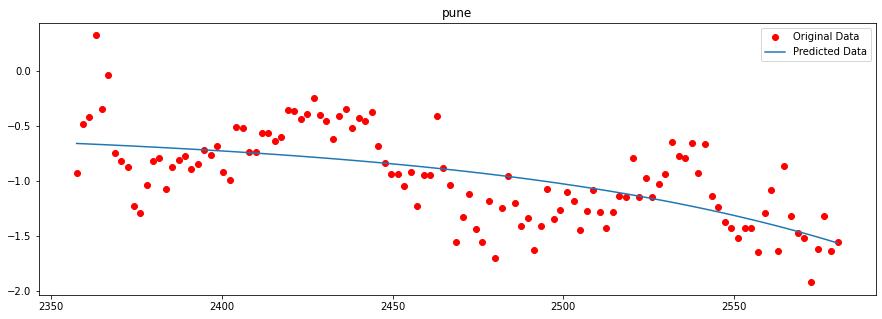

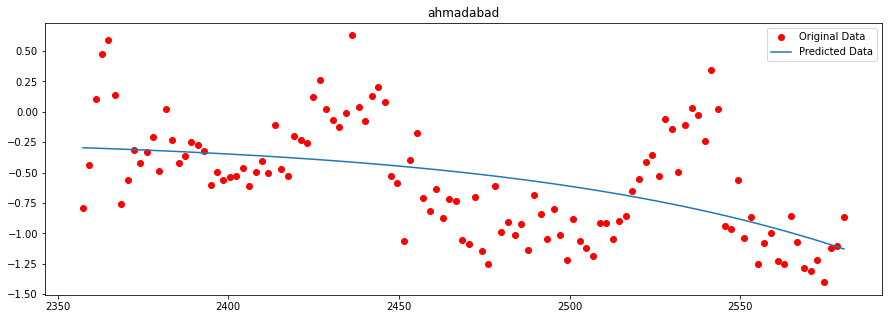

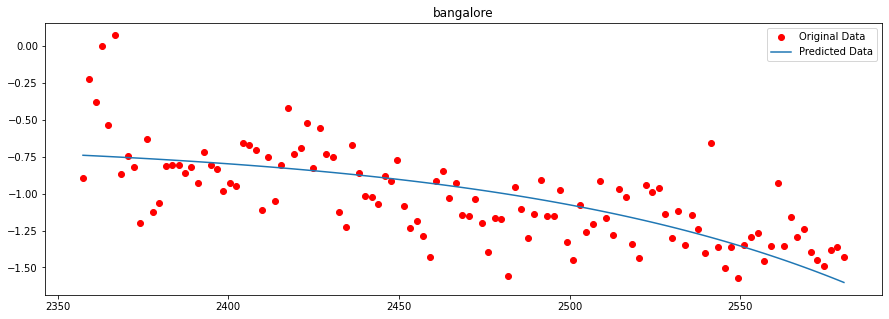

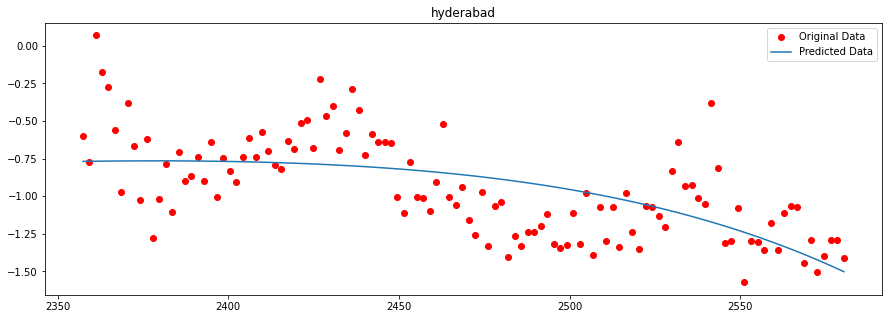

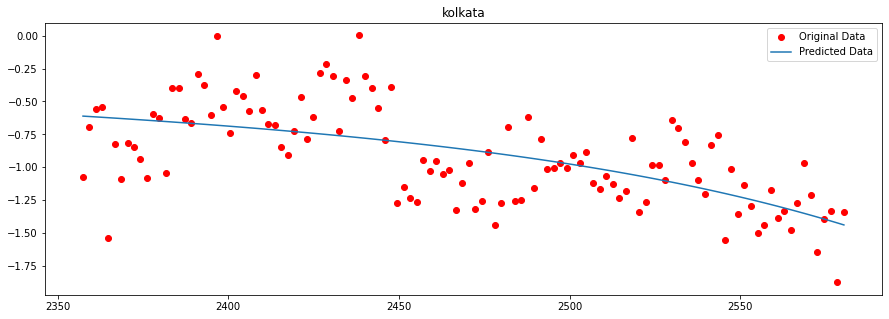

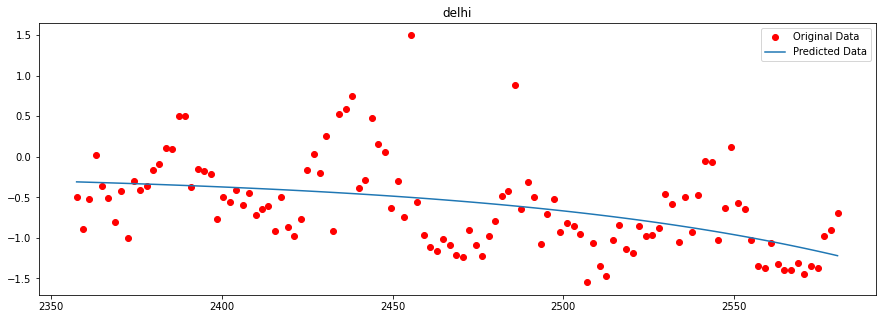

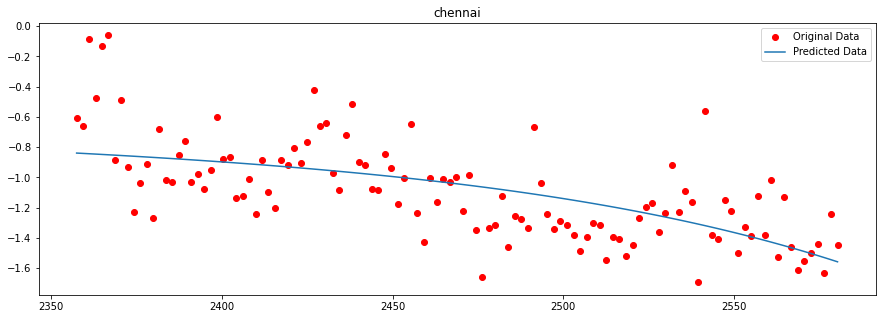

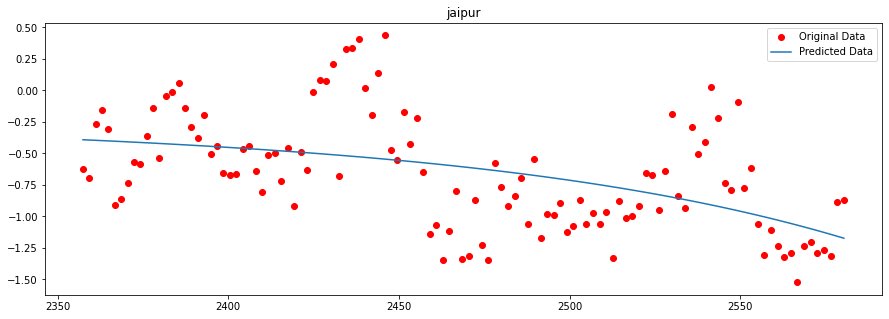

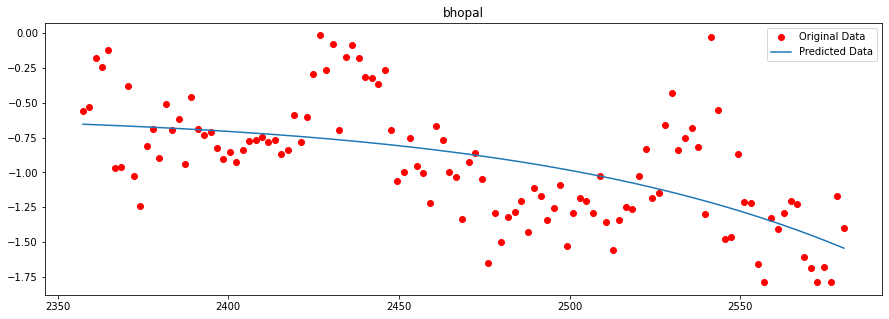

In [ ]:
final_preds = []

for i, avg_x in enumerate(new_avg):  
  x_train = [[value, value**2, np.exp(value)/10**20] for value in [float((pd.Timestamp(x).value/1000000)/(1000 * 60 * 60 * 24 * 365)) for x in avg_x['date']]]
  x_train = torch.from_numpy(np.asarray(x_train))

  y_train = [[float(value)] for value in avg_x['mean']['mean']]
  y_train = torch.from_numpy(np.array(y_train))

  model = LinearRegression()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

  num_epochs = 1000
  for epoch in range(num_epochs):
    inputs = x_train
    target = y_train

    out = model(inputs.float())
    loss = criterion(out.float(), target.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(f'Epoch[{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')

  model.eval()
  with torch.no_grad():
    predict = model(x_train.float())
    predict = predict.data.numpy()

  new_x = []
  x_pred = []
  for x in range(20):
    new_x.append(float((pd.Timestamp(avg_x['date'].max() + pd.DateOffset(days=x*7)).value/1000000)/(1000 * 60 * 60 * 24 * 365)))
  for x in new_x:
    x_pred.append([x, x**2, np.exp(x)/10**20])
  x_pred = torch.from_numpy(np.asarray(x_pred))
  with torch.no_grad():
    y_pred = model(x_pred.float())
  final_preds.append(list(y_pred))

  fig = plt.figure(figsize=(15,5))
  plt.plot(x_train.numpy().transpose()[1], y_train.numpy(), 'ro', label = 'Original Data')
  plt.plot(x_train.numpy().transpose()[1], predict, label = "Predicted Data")
  plt.legend()
  plt.title(city_names[i])
  plt.show()

We see from the graph that all the aerosol indices of various cities are decreasing. This shows that the effect of Carbon Aersol Index on climate has been attempted to be controlled. The spikes in middle show that upon noticing such elevated values, the cities have started to take measures to reduce the areosol content in the recent years.


#####Prediction of the next 20 weeks

In [ ]:
x_pred = []
for x in range(20):
  x_pred.append(avg_x['date'].max() + pd.DateOffset(days=x*7))

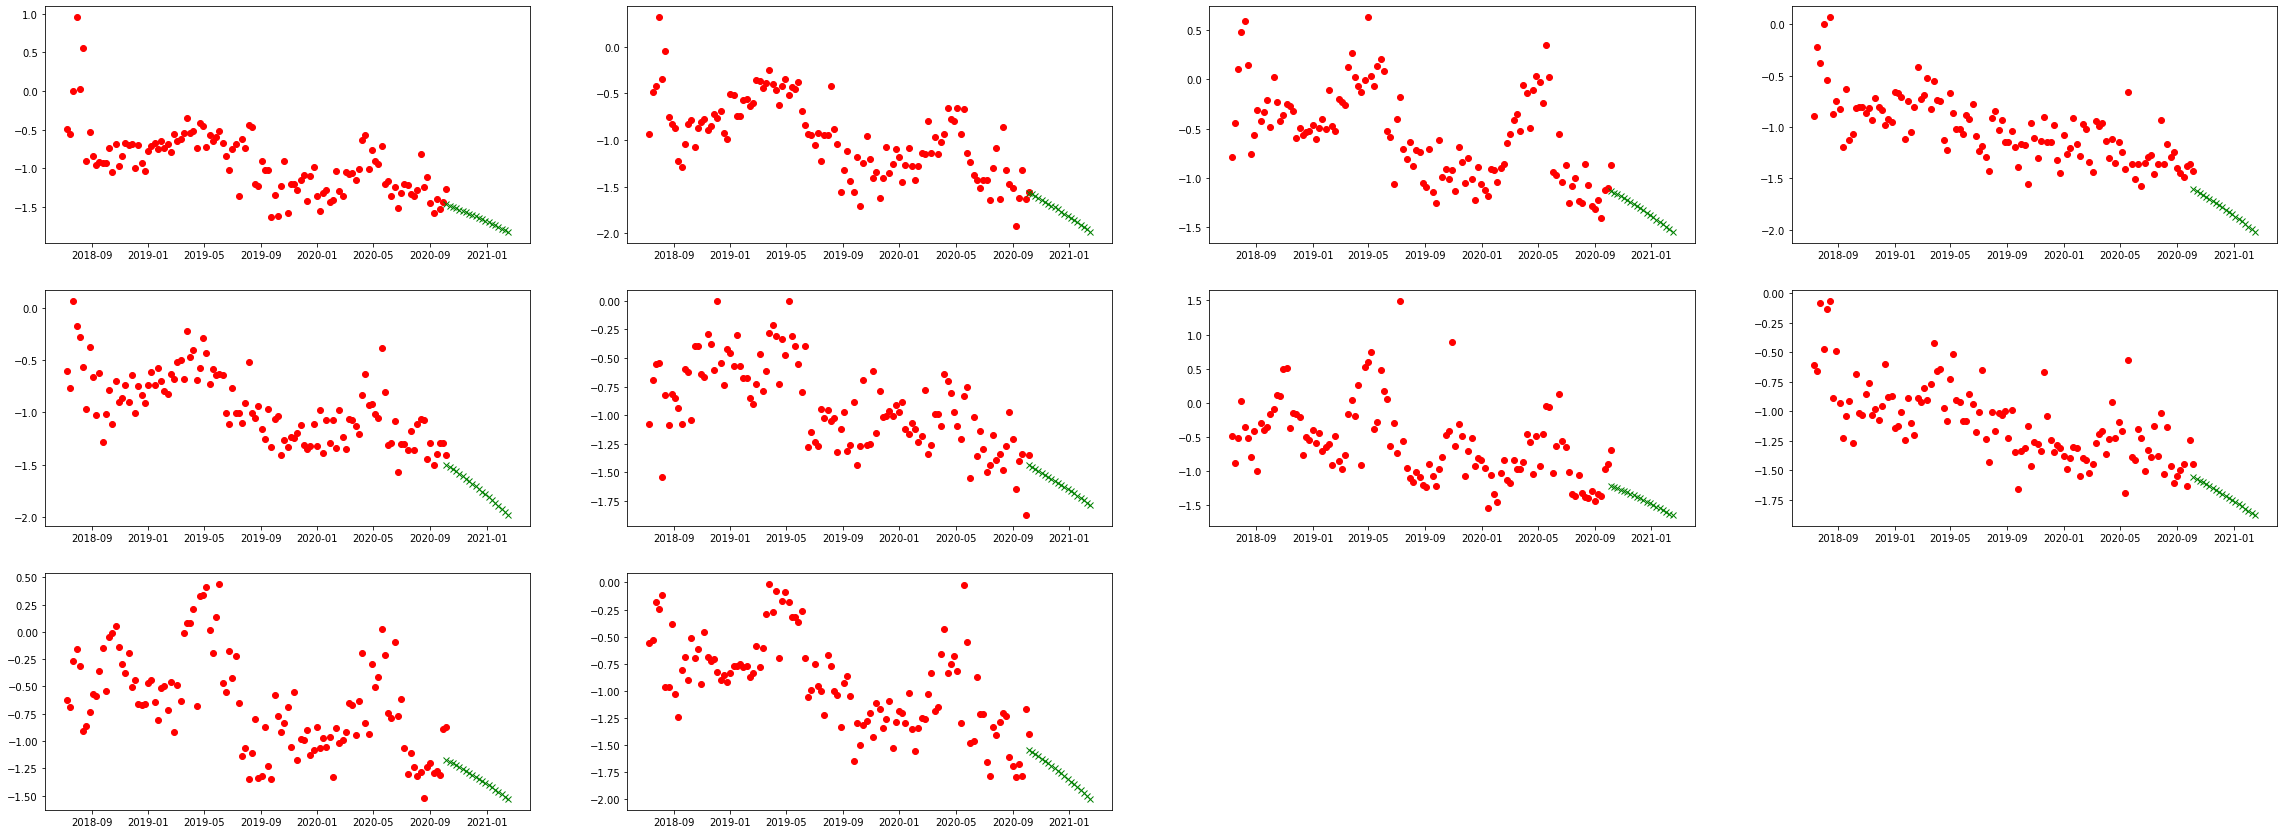

In [ ]:
fig = plt.figure(figsize=(40, 20))
i = 1
for city, preds, x in zip(city_names, final_preds, new_avg):
  fig = plt.subplot(4, 4, i)
  plt.plot(x['date'], x['mean']['mean'], 'ro')
  plt.plot(x_pred, preds, 'gx')
  i = i + 1
plt.savefig("prediction_plot.png", quality=95)

## Conclusion from ANN Predictions
The the predicted values that the model predicts shows that the mean Aerosol Index would further drop for 20 weeks after the last date in the dataset (October 2020), which tells that the pollution level would be decreasing further.